# Chargement des données

In [0]:
# On importe les librairies
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler


In [2]:
#On importe le dataset global en précisant qu'il s'agit de time series (squeeze = True)

df = pd.read_csv('https://raw.githubusercontent.com/ghassenabdedayem/AltCoins/master/data_sources/df_global_final.csv',
                 sep = ',', 
                 parse_dates=[0], 
                 index_col=0, 
                 squeeze=True)
df.head()

,GOLD_USD_AM,GOLD_USD_PM,GOLD_GBP_AM,GOLD_GBP_PM,GOLD_EUR_AM,GOLD_EUR_PM,BTC_Open,BTC_High,BTC_Low,BTC_Close,BTC_Volume,BTC_Market_Cap,BTC_Intraday,ADA_Open,ADA_High,ADA_Low,ADA_Close,ADA_Volume,ADA_Market_Cap,ADA_Intraday,LTC_Open,LTC_High,LTC_Low,LTC_Close,LTC_Volume,LTC_Market_Cap,LTC_Intraday,EOS_Open,EOS_High,EOS_Low,EOS_Close,EOS_Volume,EOS_Market_Cap,EOS_Intraday,ETH_Open,ETH_High,ETH_Low,ETH_Close,ETH_Volume,ETH_Market_Cap,...,IEF_Low,IEF_Close,IEF_Volume,NVIDIA_Open,NVIDIA_High,NVIDIA_Low,NVIDIA_Close,NVIDIA_Volume,AMD_Open,AMD_High,AMD_Low,AMD_Close,AMD_Volume,GOOGLE_Open,GOOGLE_High,GOOGLE_Low,GOOGLE_Close,GOOGLE_Volume,GPS_Open,GPS_High,GPS_Low,GPS_Close,GPS_Volume,COCOA_Open,COCOA_High,COCOA_Low,COCOA_Close,COCOA_Volume,IBM_Open,IBM_High,IBM_Low,IBM_Close,IBM_Volume,GGTrends_values,Day_Cos,Day_Sin,Month_Cos,Month_Sin,Quarter_Cos,Quarter_Sin
GOLD_Time,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2019-11-30,1456.0,1460.0,1129.55,1131.32,1323.24,1327.42,7764,7836,7515,7569,17158194786,136829391049,321,0.041416,0.042268,0.040068,0.040425,64184926,1048107282,0.002200,48.91,49.28,47.09,47.48,2678481167,3026175357,2.19,2.80,2.83,2.74,2.76,1537950803,2598670742,0.09,155,156,151,152,6565950868,16589132426,...,111.660,111.66,0.0,216.53,216.53,216.53,216.53,0.0,39.16,39.16,39.160,39.16,0.0,1304.98,1304.980,1304.98,1304.98,0.0,16.61,16.610,16.610,16.61,0.0,2512.405,2512.405,2512.405,2512.405,0.0,134.45,134.45,134.45,134.45,0.0,8.928571,0.623490,-0.781831,0.866025,-0.5,1.0,-2.449294e-16
2019-11-29,1456.0,1460.0,1129.55,1131.32,1323.24,1327.42,7466,7781,7460,7761,19709695456,140280108521,321,0.039227,0.042040,0.039194,0.041423,99506198,1073986624,0.002846,47.09,49.32,47.09,48.88,2944492393,3115330867,2.23,2.64,2.80,2.64,2.80,1899935358,2636173142,0.16,151,156,151,155,7503898278,16887922522,...,111.440,111.66,1798695.0,217.00,218.14,215.78,216.53,1881106.0,39.07,39.51,39.020,39.16,7526362.0,1305.50,1310.205,1303.97,1304.98,392185.0,16.91,16.930,16.570,16.61,1311527.0,2512.405,2512.405,2512.405,2512.405,0.0,133.59,134.51,133.04,134.45,773921.0,9.464286,-0.222521,-0.974928,0.866025,-0.5,1.0,-2.449294e-16
2019-11-28,1458.0,1455.0,1127.27,1127.35,1323.60,1321.84,7536,7730,7454,7463,19050116751,134879411013,276,0.039129,0.039990,0.038641,0.039190,60743403,1016079672,0.001349,48.00,48.55,47.02,47.06,2662459127,2998875250,1.53,2.69,2.76,2.62,2.64,1514999632,2483560320,0.14,153,156,151,151,7346531960,16496129470,...,111.660,111.66,0.0,218.24,218.24,218.24,218.24,0.0,39.41,39.41,39.410,39.41,0.0,1312.99,1312.990,1312.99,1312.99,0.0,16.91,16.910,16.910,16.91,0.0,2512.405,2512.405,2512.405,2512.405,0.0,133.76,133.76,133.76,133.76,0.0,10.714286,-0.900969,-0.433884,0.866025,-0.5,1.0,-2.449294e-16
2019-11-27,1459.8,1454.0,1134.12,1129.74,1326.23,1322.30,7220,7619,6974,7531,23991412764,136102712894,645,0.036955,0.039800,0.035783,0.039049,76841561,1012420887,0.004017,47.16,48.52,45.44,48.01,2979663352,3059223170,3.08,2.63,2.73,2.53,2.69,2247567344,2532133843,0.20,148,154,143,153,8778095308,16634910472,...,111.605,111.66,2334424.0,218.67,220.02,217.18,218.24,5314571.0,39.50,39.76,39.080,39.41,33127997.0,1315.00,1318.187,1309.63,1312.99,989345.0,17.01,17.150,16.710,16.91,0.0,2512.405,2512.405,2512.405,2512.405,0.0,135.28,135.70,133.63,133.76,0.0,11.428571,-0.900969,0.433884,0.866025,-0.5,1.0,-2.449294e-16
2019-11-26,1458.0,1455.0,1133.76,1131.86,1322.96,1321.11,7145,7320,7098,7218,21129505542,130429018720,222,0.036046,0.037074,0.035705,0.036993,57431470,959117573,0.001369,45.81,47.54,45.66,47.27,2659405400,3012041642,1.88,2.53,2.65,2.53,2.63,1894353525,2479535254,0.12,146,150,145,148,7648516297,16193326033,...,111.850,111.95,3578750.0,220.50,220.69,216.75,217.00,9487105.0,38.99,39.48,38.815,38.99,42706750.0,1309.86,1314.760,1305.09,1313.55,1011135.0,17.11,17.265,16.855,17.01,0.0,2512.405,2512.405,2512.405,2512.405,0.0,136.01,136.15,134.77,135.03,0.0,11.785714,-0.222521,0.974928,0.866025,-0.5,1.0,-2.449294e-16


# Exploration des données

/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


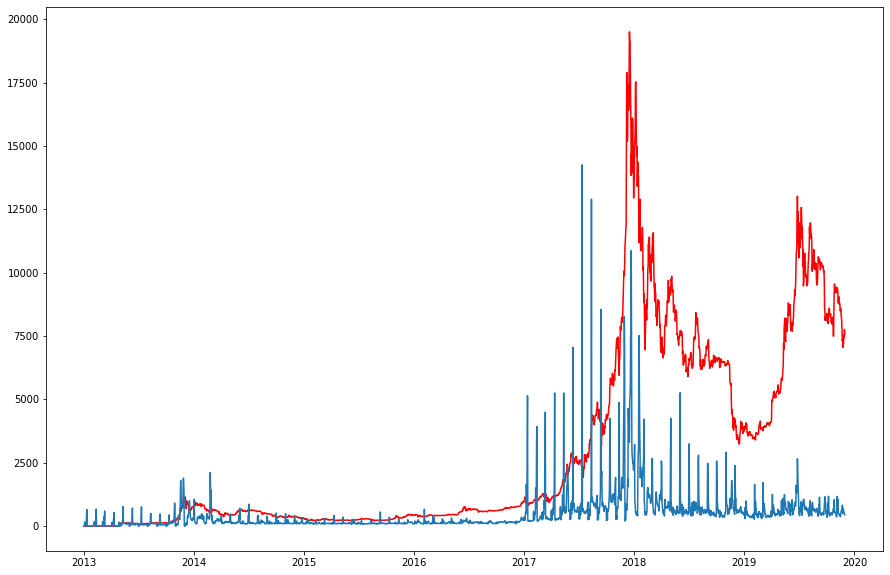

In [0]:
# On affiche Google Trends et le cours du Bitcoin BTC_Close sur le même graphique

plt.figure(figsize=(15,10))
plt.plot(df.BTC_Close, color='r')
plt.plot(df.GGTrends_values*50)
plt.show()

In [0]:
# On affiche les corrélations les plus grandes en valeur absolues

df.corr()['BTC_Close'].sort_values(ascending=True)[:20]
# On constate la grande corrélation entre les différents Altcoins et les recherches Google avec le BTC_Close

ICE_Close       -0.660399
ICE_High        -0.660199
ICE_Low         -0.659935
ICE_Open        -0.659837
CNYUSD_Low      -0.519462
CNYUSD_Open     -0.518139
CNYUSD_Close    -0.517418
CNYUSD_High     -0.517044
IBM_Close       -0.491645
IBM_High        -0.491559
IBM_Low         -0.490308
IBM_Open        -0.484886
GPS_Low         -0.427402
GPS_Close       -0.426486
GPS_Open        -0.426060
GPS_High        -0.424504
IBM_Volume      -0.405275
GPS_Volume      -0.380256
ICE_Volume      -0.355073
GOOGLE_Volume   -0.251581
Name: BTC_Close, dtype: float64

/usr/local/lib/python3.6/dist-packages/pandas/core/series.py:856: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


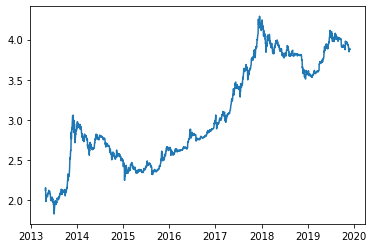

In [0]:
# On affiche le log10 du BTC_Close pour explorer les données
plt.plot(np.log10(df.BTC_Close))

/usr/local/lib/python3.6/dist-packages/pandas/core/series.py:856: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


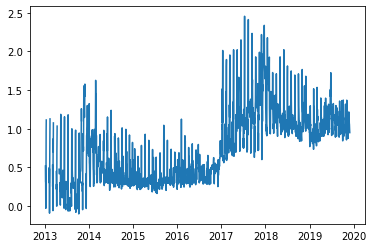

In [0]:
# On affiche également le log10 de Google Trends
plt.plot(np.log10(df.GGTrends_values))

# Préparation des données (Preprocessing)

In [0]:
# On définit une fonction qui récupère pour chaque ligne (date) les nb_day valeurs passées avec un décalage de nb_decal
# et réplique les colonnes val_exp (valeurs explicatives), chacune dans une nouvelle colonne et les juxtapose au colonnes
# contenues dans val_pred qui restent inchangées et non décalées. Cette fonction renvoie un nouveau DataFrame qui contient cette transformation
def Create_Df_Test_dec(df, val_pred, val_exp, nb_day, nb_decal):
    df2 = pd.DataFrame()
    df2['Date'] = df['GOLD_Time']
    
    # On récupère les colonnes à prédire
    for col_pred in val_pred:
        df2[col_pred] = df[col_pred]
    
    # Pour chacune des colonnes indicatives, on va récupérer les n-nb_day valeurs
    for col_exp in val_exp:
        for ii in range(nb_decal-1, nb_day):
            nb_col = ii+1
            new_col = col_exp + '_' + str(nb_col)
            df2[new_col] = 0.0
            for jj in range(len(df)):
                if ((jj+ii+1) >= len(df)):
                    df2[new_col].values[jj] = np.nan
                else:
                    df2[new_col].values[jj] = (df[col_exp].values[jj+ii+1])
    df2 = df2.set_index('Date')    
    return df2

In [61]:
# On charge à nouveau le fichier dans un DataFrame en précisant qu'il s'agit d'un TimeSeries de la colonne 0. On ne définit pas d'Index.
df_in = pd.read_csv('https://raw.githubusercontent.com/ghassenabdedayem/AltCoins/master/data_sources/df_global_final.csv',
                 sep = ',', 
                 parse_dates=[0], 
                 squeeze=True)
df_in.head()

,GOLD_Time,GOLD_USD_AM,GOLD_USD_PM,GOLD_GBP_AM,GOLD_GBP_PM,GOLD_EUR_AM,GOLD_EUR_PM,BTC_Open,BTC_High,BTC_Low,BTC_Close,BTC_Volume,BTC_Market_Cap,BTC_Intraday,ADA_Open,ADA_High,ADA_Low,ADA_Close,ADA_Volume,ADA_Market_Cap,ADA_Intraday,LTC_Open,LTC_High,LTC_Low,LTC_Close,LTC_Volume,LTC_Market_Cap,LTC_Intraday,EOS_Open,EOS_High,EOS_Low,EOS_Close,EOS_Volume,EOS_Market_Cap,EOS_Intraday,ETH_Open,ETH_High,ETH_Low,ETH_Close,ETH_Volume,...,IEF_Low,IEF_Close,IEF_Volume,NVIDIA_Open,NVIDIA_High,NVIDIA_Low,NVIDIA_Close,NVIDIA_Volume,AMD_Open,AMD_High,AMD_Low,AMD_Close,AMD_Volume,GOOGLE_Open,GOOGLE_High,GOOGLE_Low,GOOGLE_Close,GOOGLE_Volume,GPS_Open,GPS_High,GPS_Low,GPS_Close,GPS_Volume,COCOA_Open,COCOA_High,COCOA_Low,COCOA_Close,COCOA_Volume,IBM_Open,IBM_High,IBM_Low,IBM_Close,IBM_Volume,GGTrends_values,Day_Cos,Day_Sin,Month_Cos,Month_Sin,Quarter_Cos,Quarter_Sin
0,2019-11-30,1456.0,1460.0,1129.55,1131.32,1323.24,1327.42,7764,7836,7515,7569,17158194786,136829391049,321,0.041416,0.042268,0.040068,0.040425,64184926,1048107282,0.002200,48.91,49.28,47.09,47.48,2678481167,3026175357,2.19,2.80,2.83,2.74,2.76,1537950803,2598670742,0.09,155,156,151,152,6565950868,...,111.660,111.66,0.0,216.53,216.53,216.53,216.53,0.0,39.16,39.16,39.160,39.16,0.0,1304.98,1304.980,1304.98,1304.98,0.0,16.61,16.610,16.610,16.61,0.0,2512.405,2512.405,2512.405,2512.405,0.0,134.45,134.45,134.45,134.45,0.0,8.928571,0.623490,-0.781831,0.866025,-0.5,1.0,-2.449294e-16
1,2019-11-29,1456.0,1460.0,1129.55,1131.32,1323.24,1327.42,7466,7781,7460,7761,19709695456,140280108521,321,0.039227,0.042040,0.039194,0.041423,99506198,1073986624,0.002846,47.09,49.32,47.09,48.88,2944492393,3115330867,2.23,2.64,2.80,2.64,2.80,1899935358,2636173142,0.16,151,156,151,155,7503898278,...,111.440,111.66,1798695.0,217.00,218.14,215.78,216.53,1881106.0,39.07,39.51,39.020,39.16,7526362.0,1305.50,1310.205,1303.97,1304.98,392185.0,16.91,16.930,16.570,16.61,1311527.0,2512.405,2512.405,2512.405,2512.405,0.0,133.59,134.51,133.04,134.45,773921.0,9.464286,-0.222521,-0.974928,0.866025,-0.5,1.0,-2.449294e-16
2,2019-11-28,1458.0,1455.0,1127.27,1127.35,1323.60,1321.84,7536,7730,7454,7463,19050116751,134879411013,276,0.039129,0.039990,0.038641,0.039190,60743403,1016079672,0.001349,48.00,48.55,47.02,47.06,2662459127,2998875250,1.53,2.69,2.76,2.62,2.64,1514999632,2483560320,0.14,153,156,151,151,7346531960,...,111.660,111.66,0.0,218.24,218.24,218.24,218.24,0.0,39.41,39.41,39.410,39.41,0.0,1312.99,1312.990,1312.99,1312.99,0.0,16.91,16.910,16.910,16.91,0.0,2512.405,2512.405,2512.405,2512.405,0.0,133.76,133.76,133.76,133.76,0.0,10.714286,-0.900969,-0.433884,0.866025,-0.5,1.0,-2.449294e-16
3,2019-11-27,1459.8,1454.0,1134.12,1129.74,1326.23,1322.30,7220,7619,6974,7531,23991412764,136102712894,645,0.036955,0.039800,0.035783,0.039049,76841561,1012420887,0.004017,47.16,48.52,45.44,48.01,2979663352,3059223170,3.08,2.63,2.73,2.53,2.69,2247567344,2532133843,0.20,148,154,143,153,8778095308,...,111.605,111.66,2334424.0,218.67,220.02,217.18,218.24,5314571.0,39.50,39.76,39.080,39.41,33127997.0,1315.00,1318.187,1309.63,1312.99,989345.0,17.01,17.150,16.710,16.91,0.0,2512.405,2512.405,2512.405,2512.405,0.0,135.28,135.70,133.63,133.76,0.0,11.428571,-0.900969,0.433884,0.866025,-0.5,1.0,-2.449294e-16
4,2019-11-26,1458.0,1455.0,1133.76,1131.86,1322.96,1321.11,7145,7320,7098,7218,21129505542,130429018720,222,0.036046,0.037074,0.035705,0.036993,57431470,959117573,0.001369,45.81,47.54,45.66,47.27,2659405400,3012041642,1.88,2.53,2.65,2.53,2.63,1894353525,2479535254,0.12,146,150,145,148,7648516297,...,111.850,111.95,3578750.0,220.50,220.69,216.75,217.00,9487105.0,38.99,39.48,38.815,38.99,42706750.0,1309.86,1314.760,1305.09,1313.55,1011135.0,17.11,17.265,16.855,17.01,0.0,2512.405,2512.405,2512.405,2512.405,0.0,136.01,136.15,134.77,135.03,0.0,11.785714,-0.222521,0.974928,0.866025,-0.5,1.0,-2.449294e-16


In [62]:
# On précise les colonnes à répliquer et les colonnes à garder dans les deux listes val_pred et val_exp. La première colonne dans l'ordre de val_pred sera la valeur à prédire.
val_pred = ['BTC_Close', 'Day_Cos',	'Day_Sin',	'Month_Cos',	'Month_Sin',	'Quarter_Cos',	'Quarter_Sin']
val_exp = ['BTC_Close', 'BTC_Intraday', 'BTC_Volume', 'BTC_Market_Cap',
           'NVIDIA_Close', 'AMD_Close', 'GOOGLE_Close', 'GPS_Close', 'IBM_Close', #Actions \
           'GOLD_USD_PM', # Or \
           'EURGBP_Close', 'EURHUF_Close', 'EURJPY_Close', 'EURUSD_Close', 'CNYUSD_Close', 'GBPUSD_Close', # FOREX \
           'IBB_Close', 'ICE_Close', 'IEF_Close',# INDEX
           'GGTrends_values', #Google Trends
           'LTC_Close', 'BNB_Close', 'ETH_Close', 'BCH_Open', 'XLM_Close', 'XRP_Close', 'XTZ_Close',
           'BSV_Close', 'EOS_Close', 'ADA_Close'] # Autres cryptos


#On fait appel à la fonction pour transformer notre DataFrame et l'enregistrer dans df_out
df_out = Create_Df_Test_dec(df_in, val_pred, val_exp, 8, 1)

df_out.head(5)

,BTC_Close,Day_Cos,Day_Sin,Month_Cos,Month_Sin,Quarter_Cos,Quarter_Sin,BTC_Close_1,BTC_Close_2,BTC_Close_3,BTC_Close_4,BTC_Close_5,BTC_Close_6,BTC_Close_7,BTC_Close_8,BTC_Intraday_1,BTC_Intraday_2,BTC_Intraday_3,BTC_Intraday_4,BTC_Intraday_5,BTC_Intraday_6,BTC_Intraday_7,BTC_Intraday_8,BTC_Volume_1,BTC_Volume_2,BTC_Volume_3,BTC_Volume_4,BTC_Volume_5,BTC_Volume_6,BTC_Volume_7,BTC_Volume_8,BTC_Market_Cap_1,BTC_Market_Cap_2,BTC_Market_Cap_3,BTC_Market_Cap_4,BTC_Market_Cap_5,BTC_Market_Cap_6,BTC_Market_Cap_7,BTC_Market_Cap_8,NVIDIA_Close_1,...,XRP_Close_1,XRP_Close_2,XRP_Close_3,XRP_Close_4,XRP_Close_5,XRP_Close_6,XRP_Close_7,XRP_Close_8,XTZ_Close_1,XTZ_Close_2,XTZ_Close_3,XTZ_Close_4,XTZ_Close_5,XTZ_Close_6,XTZ_Close_7,XTZ_Close_8,BSV_Close_1,BSV_Close_2,BSV_Close_3,BSV_Close_4,BSV_Close_5,BSV_Close_6,BSV_Close_7,BSV_Close_8,EOS_Close_1,EOS_Close_2,EOS_Close_3,EOS_Close_4,EOS_Close_5,EOS_Close_6,EOS_Close_7,EOS_Close_8,ADA_Close_1,ADA_Close_2,ADA_Close_3,ADA_Close_4,ADA_Close_5,ADA_Close_6,ADA_Close_7,ADA_Close_8
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2019-11-30,7569,0.623490,-0.781831,0.866025,-0.5,1.0,-2.449294e-16,7761.0,7463.0,7531.0,7218.0,7146.0,7047.0,7397.0,7296.0,321.0,276.0,645.0,222.0,702.0,379.0,291.0,761.0,1.970970e+10,1.905012e+10,2.399141e+10,2.112951e+10,4.268523e+10,3.043352e+10,2.100892e+10,3.424232e+10,1.402801e+11,1.348794e+11,1.361027e+11,1.304290e+11,1.291130e+11,1.273274e+11,1.336362e+11,1.317918e+11,216.53,...,0.230217,0.224570,0.225081,0.222145,0.218622,0.223184,0.236188,0.231600,1.31,1.28,1.26,1.24,1.24,1.34,1.39,1.22,109.52,106.34,107.86,107.79,104.54,100.41,109.24,96.95,2.80,2.64,2.69,2.63,2.54,2.45,2.72,2.63,0.041423,0.039190,0.039049,0.036993,0.036048,0.035588,0.038343,0.037148
2019-11-29,7761,-0.222521,-0.974928,0.866025,-0.5,1.0,-2.449294e-16,7463.0,7531.0,7218.0,7146.0,7047.0,7397.0,7296.0,7642.0,276.0,645.0,222.0,702.0,379.0,291.0,761.0,513.0,1.905012e+10,2.399141e+10,2.112951e+10,4.268523e+10,3.043352e+10,2.100892e+10,3.424232e+10,2.251424e+10,1.348794e+11,1.361027e+11,1.304290e+11,1.291130e+11,1.273274e+11,1.336362e+11,1.317918e+11,1.380319e+11,218.24,...,0.224570,0.225081,0.222145,0.218622,0.223184,0.236188,0.231600,0.243766,1.28,1.26,1.24,1.24,1.34,1.39,1.22,1.21,106.34,107.86,107.79,104.54,100.41,109.24,96.95,100.26,2.64,2.69,2.63,2.54,2.45,2.72,2.63,2.83,0.039190,0.039049,0.036993,0.036048,0.035588,0.038343,0.037148,0.038406
2019-11-28,7463,-0.900969,-0.433884,0.866025,-0.5,1.0,-2.449294e-16,7531.0,7218.0,7146.0,7047.0,7397.0,7296.0,7642.0,8027.0,645.0,222.0,702.0,379.0,291.0,761.0,513.0,227.0,2.399141e+10,2.112951e+10,4.268523e+10,3.043352e+10,2.100892e+10,3.424232e+10,2.251424e+10,2.076430e+10,1.361027e+11,1.304290e+11,1.291130e+11,1.273274e+11,1.336362e+11,1.317918e+11,1.380319e+11,1.449627e+11,218.24,...,0.225081,0.222145,0.218622,0.223184,0.236188,0.231600,0.243766,0.251364,1.26,1.24,1.24,1.34,1.39,1.22,1.21,1.21,107.86,107.79,104.54,100.41,109.24,96.95,100.26,106.55,2.69,2.63,2.54,2.45,2.72,2.63,2.83,3.10,0.039049,0.036993,0.036048,0.035588,0.038343,0.037148,0.038406,0.041178
2019-11-27,7531,-0.900969,0.433884,0.866025,-0.5,1.0,-2.449294e-16,7218.0,7146.0,7047.0,7397.0,7296.0,7642.0,8027.0,8206.0,222.0,702.0,379.0,291.0,761.0,513.0,227.0,309.0,2.112951e+10,4.268523e+10,3.043352e+10,2.100892e+10,3.424232e+10,2.251424e+10,2.076430e+10,2.108361e+10,1.304290e+11,1.291130e+11,1.273274e+11,1.336362e+11,1.317918e+11,1.380319e+11,1.449627e+11,1.481784e+11,217.00,...,0.222145,0.218622,0.223184,0.236188,0.231600,0.243766,0.251364,0.256500,1.24,1.24,1.34,1.39,1.22,1.21,1.21,1.22,107.79,104.54,100.41,109.24,96.95,100.26,106.55,110.48,2.63,2.54,2.45,2.72,2.63,2.83,3.10,3.15,0.036993,0.036048,0.035588,0.038343,0.037148,0.038406,0.041178,0.042542
2019-11-26,7218,-0.222521,0.974928,0.866025,-0.5,1.0,-2.449294e-16,7146.0,7047.0,7397.0,7296.0,7642.0,8027.0,8206.0,8309.0,702.0,379.0,291.0,761.0,513.0,227.0,309.0,380.0,4.268523e+10,3.043352e+10,2.100892e+10,

In [0]:
# On remplace les NaN par 0
df_out = df_out.ffill()

In [64]:
# On divise en data (explicatives) et target
data = df_out.iloc[:, 1:]
target = df_out['BTC_Close']
data.head()

,Day_Cos,Day_Sin,Month_Cos,Month_Sin,Quarter_Cos,Quarter_Sin,BTC_Close_1,BTC_Close_2,BTC_Close_3,BTC_Close_4,BTC_Close_5,BTC_Close_6,BTC_Close_7,BTC_Close_8,BTC_Intraday_1,BTC_Intraday_2,BTC_Intraday_3,BTC_Intraday_4,BTC_Intraday_5,BTC_Intraday_6,BTC_Intraday_7,BTC_Intraday_8,BTC_Volume_1,BTC_Volume_2,BTC_Volume_3,BTC_Volume_4,BTC_Volume_5,BTC_Volume_6,BTC_Volume_7,BTC_Volume_8,BTC_Market_Cap_1,BTC_Market_Cap_2,BTC_Market_Cap_3,BTC_Market_Cap_4,BTC_Market_Cap_5,BTC_Market_Cap_6,BTC_Market_Cap_7,BTC_Market_Cap_8,NVIDIA_Close_1,NVIDIA_Close_2,...,XRP_Close_1,XRP_Close_2,XRP_Close_3,XRP_Close_4,XRP_Close_5,XRP_Close_6,XRP_Close_7,XRP_Close_8,XTZ_Close_1,XTZ_Close_2,XTZ_Close_3,XTZ_Close_4,XTZ_Close_5,XTZ_Close_6,XTZ_Close_7,XTZ_Close_8,BSV_Close_1,BSV_Close_2,BSV_Close_3,BSV_Close_4,BSV_Close_5,BSV_Close_6,BSV_Close_7,BSV_Close_8,EOS_Close_1,EOS_Close_2,EOS_Close_3,EOS_Close_4,EOS_Close_5,EOS_Close_6,EOS_Close_7,EOS_Close_8,ADA_Close_1,ADA_Close_2,ADA_Close_3,ADA_Close_4,ADA_Close_5,ADA_Close_6,ADA_Close_7,ADA_Close_8
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2019-11-30,0.623490,-0.781831,0.866025,-0.5,1.0,-2.449294e-16,7761.0,7463.0,7531.0,7218.0,7146.0,7047.0,7397.0,7296.0,321.0,276.0,645.0,222.0,702.0,379.0,291.0,761.0,1.970970e+10,1.905012e+10,2.399141e+10,2.112951e+10,4.268523e+10,3.043352e+10,2.100892e+10,3.424232e+10,1.402801e+11,1.348794e+11,1.361027e+11,1.304290e+11,1.291130e+11,1.273274e+11,1.336362e+11,1.317918e+11,216.53,218.24,...,0.230217,0.224570,0.225081,0.222145,0.218622,0.223184,0.236188,0.231600,1.31,1.28,1.26,1.24,1.24,1.34,1.39,1.22,109.52,106.34,107.86,107.79,104.54,100.41,109.24,96.95,2.80,2.64,2.69,2.63,2.54,2.45,2.72,2.63,0.041423,0.039190,0.039049,0.036993,0.036048,0.035588,0.038343,0.037148
2019-11-29,-0.222521,-0.974928,0.866025,-0.5,1.0,-2.449294e-16,7463.0,7531.0,7218.0,7146.0,7047.0,7397.0,7296.0,7642.0,276.0,645.0,222.0,702.0,379.0,291.0,761.0,513.0,1.905012e+10,2.399141e+10,2.112951e+10,4.268523e+10,3.043352e+10,2.100892e+10,3.424232e+10,2.251424e+10,1.348794e+11,1.361027e+11,1.304290e+11,1.291130e+11,1.273274e+11,1.336362e+11,1.317918e+11,1.380319e+11,218.24,218.24,...,0.224570,0.225081,0.222145,0.218622,0.223184,0.236188,0.231600,0.243766,1.28,1.26,1.24,1.24,1.34,1.39,1.22,1.21,106.34,107.86,107.79,104.54,100.41,109.24,96.95,100.26,2.64,2.69,2.63,2.54,2.45,2.72,2.63,2.83,0.039190,0.039049,0.036993,0.036048,0.035588,0.038343,0.037148,0.038406
2019-11-28,-0.900969,-0.433884,0.866025,-0.5,1.0,-2.449294e-16,7531.0,7218.0,7146.0,7047.0,7397.0,7296.0,7642.0,8027.0,645.0,222.0,702.0,379.0,291.0,761.0,513.0,227.0,2.399141e+10,2.112951e+10,4.268523e+10,3.043352e+10,2.100892e+10,3.424232e+10,2.251424e+10,2.076430e+10,1.361027e+11,1.304290e+11,1.291130e+11,1.273274e+11,1.336362e+11,1.317918e+11,1.380319e+11,1.449627e+11,218.24,217.00,...,0.225081,0.222145,0.218622,0.223184,0.236188,0.231600,0.243766,0.251364,1.26,1.24,1.24,1.34,1.39,1.22,1.21,1.21,107.86,107.79,104.54,100.41,109.24,96.95,100.26,106.55,2.69,2.63,2.54,2.45,2.72,2.63,2.83,3.10,0.039049,0.036993,0.036048,0.035588,0.038343,0.037148,0.038406,0.041178
2019-11-27,-0.900969,0.433884,0.866025,-0.5,1.0,-2.449294e-16,7218.0,7146.0,7047.0,7397.0,7296.0,7642.0,8027.0,8206.0,222.0,702.0,379.0,291.0,761.0,513.0,227.0,309.0,2.112951e+10,4.268523e+10,3.043352e+10,2.100892e+10,3.424232e+10,2.251424e+10,2.076430e+10,2.108361e+10,1.304290e+11,1.291130e+11,1.273274e+11,1.336362e+11,1.317918e+11,1.380319e+11,1.449627e+11,1.481784e+11,217.00,221.21,...,0.222145,0.218622,0.223184,0.236188,0.231600,0.243766,0.251364,0.256500,1.24,1.24,1.34,1.39,1.22,1.21,1.21,1.22,107.79,104.54,100.41,109.24,96.95,100.26,106.55,110.48,2.63,2.54,2.45,2.72,2.63,2.83,3.10,3.15,0.036993,0.036048,0.035588,0.038343,0.037148,0.038406,0.041178,0.042542
2019-11-26,-0.222521,0.974928,0.866025,-0.5,1.0,-2.449294e-16,7146.0,7047.0,7397.0,7296.0,7642.0,8027.0,8206.0,8309.0,702.0,379.0,291.0,761.0,513.0,227.0,309.0,380.0,4.268523e+10,3.043352e+10,2.100

In [0]:
#On définit une fonction qui normalise les données explicatives sauf les colonnes relatives aux dates (seasonality)

def std_scaler(data, seasonality):
  scaler = StandardScaler()

  transformed_data = pd.DataFrame(scaler.fit_transform(data), columns=data.columns, index=data.index)
  data.head()
  seasonality = ['Day_Cos',	'Day_Sin',	'Month_Cos',	'Month_Sin',	'Quarter_Cos',	'Quarter_Sin']
  for season in seasonality:
    transformed_data[season] = df_out[season]

  return transformed_data

In [66]:
#On définit la liste des colonnes à ne pas scaler, puis on scale les données avec la fonction

excluded_col = ['Day_Cos',	'Day_Sin',	'Month_Cos',	'Month_Sin',	'Quarter_Cos',	'Quarter_Sin']

scaled_data = std_scaler(data, excluded_col)

scaled_data.head()

,Day_Cos,Day_Sin,Month_Cos,Month_Sin,Quarter_Cos,Quarter_Sin,BTC_Close_1,BTC_Close_2,BTC_Close_3,BTC_Close_4,BTC_Close_5,BTC_Close_6,BTC_Close_7,BTC_Close_8,BTC_Intraday_1,BTC_Intraday_2,BTC_Intraday_3,BTC_Intraday_4,BTC_Intraday_5,BTC_Intraday_6,BTC_Intraday_7,BTC_Intraday_8,BTC_Volume_1,BTC_Volume_2,BTC_Volume_3,BTC_Volume_4,BTC_Volume_5,BTC_Volume_6,BTC_Volume_7,BTC_Volume_8,BTC_Market_Cap_1,BTC_Market_Cap_2,BTC_Market_Cap_3,BTC_Market_Cap_4,BTC_Market_Cap_5,BTC_Market_Cap_6,BTC_Market_Cap_7,BTC_Market_Cap_8,NVIDIA_Close_1,NVIDIA_Close_2,...,XRP_Close_1,XRP_Close_2,XRP_Close_3,XRP_Close_4,XRP_Close_5,XRP_Close_6,XRP_Close_7,XRP_Close_8,XTZ_Close_1,XTZ_Close_2,XTZ_Close_3,XTZ_Close_4,XTZ_Close_5,XTZ_Close_6,XTZ_Close_7,XTZ_Close_8,BSV_Close_1,BSV_Close_2,BSV_Close_3,BSV_Close_4,BSV_Close_5,BSV_Close_6,BSV_Close_7,BSV_Close_8,EOS_Close_1,EOS_Close_2,EOS_Close_3,EOS_Close_4,EOS_Close_5,EOS_Close_6,EOS_Close_7,EOS_Close_8,ADA_Close_1,ADA_Close_2,ADA_Close_3,ADA_Close_4,ADA_Close_5,ADA_Close_6,ADA_Close_7,ADA_Close_8
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2019-11-30,0.623490,-0.781831,0.866025,-0.5,1.0,-2.449294e-16,1.311137,1.232382,1.251628,1.168746,1.150384,1.124757,1.219539,1.193444,0.441697,0.314139,1.363331,0.161722,1.526764,0.609412,0.359531,1.696792,2.547007,2.448252,3.225492,2.784680,6.175274,4.286090,2.806789,4.916962,1.409682,1.327735,1.347722,1.261440,1.242204,1.215701,1.313990,1.286659,1.451470,1.472938,...,-0.196025,-0.196291,-0.196263,-0.196399,-0.196563,-0.196340,-0.195712,-0.195928,0.774275,0.746512,0.728165,0.709805,0.710308,0.805205,0.852976,0.693083,2.147555,2.075803,2.114202,2.115355,2.041669,1.946978,2.157438,1.870427,0.338173,0.289927,0.305412,0.287511,0.260498,0.233474,0.315710,0.288710,-0.023961,-0.044028,-0.045163,-0.063634,-0.072054,-0.076087,-0.051019,-0.061697
2019-11-29,-0.222521,-0.974928,0.866025,-0.5,1.0,-2.449294e-16,1.231284,1.250607,1.167722,1.149441,1.123835,1.218628,1.192447,1.286272,0.313780,1.363053,0.160945,1.526573,0.608368,0.359094,1.696495,0.991343,2.444029,3.220669,2.777616,6.164829,4.251239,2.794828,4.908251,3.051741,1.326507,1.346580,1.260297,1.241156,1.214678,1.312975,1.285546,1.382913,1.471639,1.472938,...,-0.196296,-0.196267,-0.196403,-0.196568,-0.196345,-0.195717,-0.195932,-0.195344,0.745967,0.727638,0.709290,0.709805,0.804696,0.852402,0.692494,0.683642,2.072966,2.111487,2.112557,2.038930,1.944467,2.154960,1.867752,1.948516,0.289600,0.305106,0.287198,0.260191,0.233178,0.315429,0.288393,0.349412,-0.044177,-0.045304,-0.063775,-0.072189,-0.076218,-0.051148,-0.061836,-0.050310
2019-11-28,-0.900969,-0.433884,0.866025,-0.5,1.0,-2.449294e-16,1.249506,1.166716,1.148421,1.122897,1.217693,1.191539,1.285257,1.389562,1.362700,0.160639,1.525354,0.608142,0.358155,1.696018,0.991033,0.177800,3.215497,2.773299,6.150992,4.243641,2.771181,4.888759,3.045834,2.773431,1.345347,1.259177,1.240019,1.213636,1.311933,1.284536,1.381778,1.489821,1.471639,1.458309,...,-0.196271,-0.196408,-0.196572,-0.196349,-0.195721,-0.195937,-0.195349,-0.194980,0.727094,0.708764,0.709290,0.804187,0.851890,0.691934,0.683053,0.683642,2.108619,2.109843,2.036197,1.941812,2.152285,1.865481,1.945771,2.096908,0.304779,0.286891,0.259877,0.232871,0.315136,0.288111,0.349097,0.431361,-0.045454,-0.063918,-0.072331,-0.076353,-0.051279,-0.061966,-0.050449,-0.025220
2019-11-27,-0.900969,0.433884,0.866025,-0.5,1.0,-2.449294e-16,1.165634,1.147419,1.121882,1.216740,1.190608,1.284337,1.388529,1.437585,0.160279,1.525081,0.607220,0.357919,1.694521,0.990577,0.177476,0.411054,2.768677,6.142861,4.233653,2.765772,4.849380,3.033016,2.767943,2.824215,1.257968,1.238903,1.212505,1.310871,1.283500,1.380751,1.488662,1.539423,1.457013,1.507978,...,-0.196412,-0.196577,-0.196353,-0.195725,-0.195941,-0.195353,-0.194985,-0.194734,0.708222,0.708764,0.803666,0.851378,0.691431,0.682494,0.683053,0.693083,2.106977,2.033546,1.939161,2.149453,1.863035,1.943445,2.094032,2.189624,0.286564,0.259569,0.232556,0.314831,0.287

# X_train, y_train, X_test, y_test

In [0]:
# On découpe les données en échantillon d'entrainement et échantillon de test. Ici on a choisit les time_window=100 dernières valeurs dans le temps comme échantillon de test.
# On peu aussi découper les données de façon aléatoire avec train_test_split si on veut.

time_window = 100

y_train = np.asarray(target)[time_window:]
y_test = target[:time_window]
X_train = np.asarray(scaled_data)[time_window:, :]
X_test = np.asarray(scaled_data)[:time_window, :]

# Feature selection

In [0]:
from sklearn.feature_selection import VarianceThreshold, SelectKBest, SelectFromModel, f_regression, mutual_info_regression, RFE, RFECV


In [85]:
np.abs(df_out.corr().BTC_Close).sort_values(ascending=False)[140:160]

EURHUF_Close_3    0.563545
BSV_Close_2       0.562811
EURHUF_Close_4    0.562006
BSV_Close_3       0.561916
BSV_Close_4       0.561011
EURHUF_Close_5    0.560711
BSV_Close_5       0.559838
EURHUF_Close_6    0.559500
EURHUF_Close_7    0.558913
EURHUF_Close_8    0.558807
BSV_Close_6       0.558668
BSV_Close_7       0.557882
BSV_Close_8       0.557255
CNYUSD_Close_8    0.526092
CNYUSD_Close_7    0.524714
CNYUSD_Close_6    0.523433
CNYUSD_Close_5    0.522216
CNYUSD_Close_4    0.521021
CNYUSD_Close_3    0.519814
CNYUSD_Close_2    0.519052
Name: BTC_Close, dtype: float64

In [0]:
sel = SelectKBest(score_func = f_regression, k = 160)
sel.fit(X_train, y_train)
mask = sel.get_support()

In [0]:
X_train = sel.transform(X_train)
X_test = sel.transform(X_test)

# Modèle de prédiction

In [0]:
# importation des librairies
# importation des librairies
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.model_selection import train_test_split,KFold,GridSearchCV,RandomizedSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import StratifiedKFold 
from sklearn.model_selection import cross_val_score
import xgboost as xgb

In [89]:
dnorm=xgb.DMatrix(scaled_data, label=target)
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


In [90]:
# On instancie le predicteur
xg1=xgb.XGBRegressor(objective ='reg:squarederror', colsample_bytree = 0.3, learning_rate = 0.1,
                max_depth = 5, alpha = 10,eval_metric='rmse',n_estimators = 50)#objective='reg:squarederror'
xg1.fit(X_train,y_train)

XGBRegressor(alpha=10, base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.3, eval_metric='rmse',
             gamma=0, importance_type='gain', learning_rate=0.1,
             max_delta_step=0, max_depth=5, min_child_weight=1, missing=None,
             n_estimators=50, n_jobs=1, nthread=None,
             objective='reg:squarederror', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=None,
             subsample=1, verbosity=1)

In [91]:
ypred1=xg1.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, ypred1))
print("RMSE_baseline: %f" % (rmse))

RMSE_baseline: 346.165782


In [0]:
# On l'entraine sur le set d'entrainement
params = {"objective":"reg:squarederror",'colsample_bytree': 0.3,'learning_rate': 0.1,
                'max_depth': 5, 'alpha': 10}

cv_results = xgb.cv(dtrain=dnorm, params=params, nfold=5,
                    num_boost_round=50,early_stopping_rounds=10,metrics="rmse", as_pandas=True, seed=123)

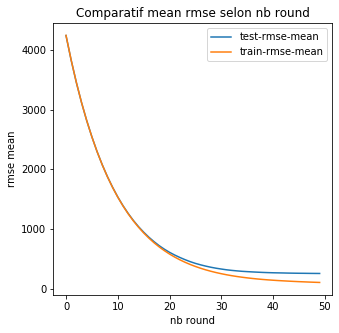

In [93]:
fig=plt.figure(figsize=(5,5))
ax1=fig.add_subplot(111)

ax1.plot(cv_results["test-rmse-mean"],label='test-rmse-mean')
ax1.plot(cv_results["train-rmse-mean"],label='train-rmse-mean')
ax1.set_ylabel('rmse mean')
ax1.set_xlabel('nb round')
ax1.legend(loc='best')
ax1.set_title('Comparatif mean rmse selon nb round');

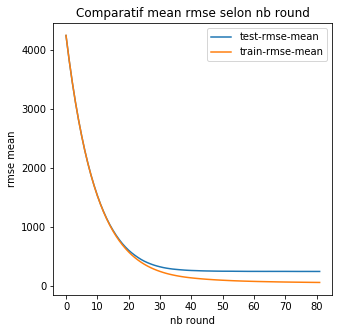

In [94]:
cv_results2 = xgb.cv(dtrain=dnorm, params=params, nfold=5,
                    num_boost_round=100,early_stopping_rounds=10,metrics="rmse", as_pandas=True, seed=123)

fig=plt.figure(figsize=(5,5))
ax1=fig.add_subplot(111)

ax1.plot(cv_results2["test-rmse-mean"],label='test-rmse-mean')
ax1.plot(cv_results2["train-rmse-mean"],label='train-rmse-mean')
ax1.set_ylabel('rmse mean')
ax1.set_xlabel('nb round')
ax1.legend(loc='best')
ax1.set_title('Comparatif mean rmse selon nb round');

In [0]:
# On prédit les valeurs pour l'échantillon de test (y_pred) et pour l'échantillon d'entrainement (y_train_pred)
from xgboost import XGBRegressor

estimator = XGBRegressor(
    objective= 'reg:squarederror',
    nthread=4,
    seed=42,
    n_estimators = 35 ################ On prend 35 rounds ####################
)


params = {"objective":"reg:squarederror",'colsample_bytree': 0.3,'learning_rate': 0.1,
                'max_depth': 5, 'alpha': 10}
parameters = {
    'max_depth': range (2, 6, 1),
    'colsample_bytree': np.arange(0.1, 0.4,0.1),
    'alpha': np.arange(1,10,1),
    'learning_rate': np.arange(0.01, 0.1,0.01)
}

In [0]:
grid_search = GridSearchCV(
    estimator=estimator,
    param_grid=parameters,
    scoring = 'neg_mean_squared_error',
    n_jobs = 5,
    cv = 5,
    verbose=True
)

In [97]:
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 1296 candidates, totalling 6480 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:    9.2s
[Parallel(n_jobs=5)]: Done 190 tasks      | elapsed:   29.6s
[Parallel(n_jobs=5)]: Done 440 tasks      | elapsed:  1.3min
[Parallel(n_jobs=5)]: Done 790 tasks      | elapsed:  2.6min
[Parallel(n_jobs=5)]: Done 1240 tasks      | elapsed:  3.9min
[Parallel(n_jobs=5)]: Done 1790 tasks      | elapsed:  5.7min
[Parallel(n_jobs=5)]: Done 2440 tasks      | elapsed:  7.8min
[Parallel(n_jobs=5)]: Done 3190 tasks      | elapsed: 10.3min
[Parallel(n_jobs=5)]: Done 4040 tasks      | elapsed: 13.1min
[Parallel(n_jobs=5)]: Done 4990 tasks      | elapsed: 16.4min
[Parallel(n_jobs=5)]: Done 6040 tasks      | elapsed: 19.7min
[Parallel(n_jobs=5)]: Done 6480 out of 6480 | elapsed: 21.3min finished


GridSearchCV(cv=5, error_score=nan,
             estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                                    colsample_bylevel=1, colsample_bynode=1,
                                    colsample_bytree=1, gamma=0,
                                    importance_type='gain', learning_rate=0.1,
                                    max_delta_step=0, max_depth=3,
                                    min_child_weight=1, missing=None,
                                    n_estimators=35, n_jobs=1, nthread=4,
                                    objective='reg:squarederror',
                                    random_state=0, reg_alpha=0, re...
                                    scale_pos_weight=1, seed=42, silent=None,
                                    subsample=1, verbosity=1),
             iid='deprecated', n_jobs=5,
             param_grid={'alpha': array([1, 2, 3, 4, 5, 6, 7, 8, 9]),
                         'colsample_bytree': array([0.1, 0.2, 0.3, 0.4]),

In [105]:
np.sqrt(13144129)

3625.4832781299656

In [98]:
grid_search.best_estimator_

XGBRegressor(alpha=1, base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.2, gamma=0,
             importance_type='gain', learning_rate=0.09, max_delta_step=0,
             max_depth=2, min_child_weight=1, missing=None, n_estimators=35,
             n_jobs=1, nthread=4, objective='reg:squarederror', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=42,
             silent=None, subsample=1, verbosity=1)

In [0]:
results = pd.DataFrame(grid_search.cv_results_)

In [100]:
ypred_rs=grid_search.predict(X_test)
rmse2 = np.sqrt(mean_squared_error(y_test, ypred_rs))
diff_rs=abs(y_test-ypred_rs)
print("RMSE_grid_search: %f" % (rmse2))
print("Nous passons donc d'une rmse de ",round(rmse,2)," avant le paramètrage des hyperparamètres à une rsme de ",round(rmse2,2)," après paramètrage des hyperparamètres." )

RMSE_grid_search: 378.050569
Nous passons donc d'une rmse de  346.17  avant le paramètrage des hyperparamètres à une rsme de  378.05  après paramètrage des hyperparamètres.


In [0]:
y_pred = ypred_rs
y_train_pred = grid_search.predict(X_train)

# Evaluation des résultats

In [102]:
# On affiche la racine de l'erreur quadratique moyenne

print("La racine carrée de l'erreur quadratique moyenne sur les données d'entrainement : ", np.round(np.sqrt(mean_squared_error(y_train_pred, y_train))))
print("La racine carrée de l'erreur quadratique moyenne sur les données de test : ", np.round(np.sqrt(mean_squared_error(y_pred, y_test))))

La racine carrée de l'erreur quadratique moyenne sur les données d'entrainement :  339.0
La racine carrée de l'erreur quadratique moyenne sur les données de test :  378.0


In [103]:
# On crée un DataFrame qui contient les valeurs prédites et les valeurs réelles pour l'échantillon de test
df_result = pd.DataFrame()
df_result['BTC_Close_Reel'] = y_test
df_result['BTC_Close_Pred'] = y_pred
df_result.head(10)

,BTC_Close_Reel,BTC_Close_Pred
Date,,
2019-11-30,7569,7494.152344
2019-11-29,7761,7289.757324
2019-11-28,7463,7023.063477
2019-11-27,7531,6932.514160
2019-11-26,7218,6932.514160
2019-11-25,7146,7009.473145
2019-11-24,7047,7068.981934
2019-11-23,7397,7395.466797
2019-11-22,7296,7712.972656


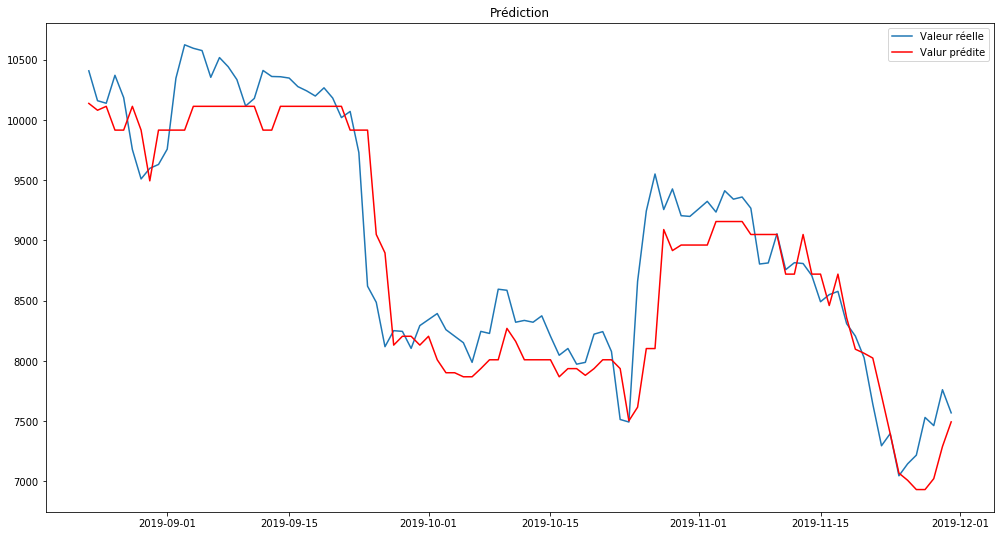

In [104]:
# On affiche les deux courbes pour comparer
plt.figure(figsize=(17, 9))
plt.plot(df_result.index, df_result['BTC_Close_Reel'], label='Valeur réelle')
plt.plot(df_result.index, df_result['BTC_Close_Pred'], color='r', label='Valur prédite')
plt.title('Prédiction')
plt.legend()
plt.show()